In [97]:
def pconv(f,h):
    import numpy as np

    h_ind=np.nonzero(h)
    f_ind=np.nonzero(f)
    if len(h_ind[0])>len(f_ind[0]):
        h,    f    = f,    h
        h_ind,f_ind= f_ind,h_ind

    gs = np.maximum(np.array(f.shape),np.array(h.shape))
    if (f.dtype == 'complex') or (h.dtype == 'complex'):
        g = np.zeros(gs,dtype='complex')
    else:
        g = np.zeros(gs)

    f1 = g.copy()
    f1[f_ind]=f[f_ind]      

    if f.ndim == 1:
        (W,) = gs
        col = np.arange(W)
        for cc in h_ind[0]:
            g[:] += f1[(col-cc)%W] * h[cc]

    elif f.ndim == 2:
        H,W = gs
        row,col = np.indices(gs)
        for rr,cc in np.transpose(h_ind):
            g[:] += f1[(row-rr)%H, (col-cc)%W] * h[rr,cc]

    else:
        Z,H,W = gs
        d,row,col = np.indices(gs)
        for dd,rr,cc in np.transpose(h_ind):
            g[:] += f1[(d-dd)%Z, (row-rr)%H, (col-cc)%W] * h[dd,rr,cc]
    return g

def iasobel(f):
#     from pconv import pconv
    
    Sx = np.array([[1.,2.,1.],
                   [0.,0.,0.],
                   [-1.,-2.,-1.]])
    Sy = np.array([[1.,0.,-1.],
                   [2.,0.,-2.],
                   [1.,0.,-1.]])
    
    fx = pconv(f, Sx)
    fy = pconv(f, Sy)
    
    mag = np.abs(fx + fy*1j)
    theta = np.arctan2(fy,fx)
    print('{} {} {} {}'.format(fx.min(), fx.max(), fy.min(), fy.max()))
    return mag,theta

# Ex05 - Filtros de aguçamento

## 1. Unsharp mask

Um filtro bastante utilizado para aguçar a imagem é denominado *unsharp mask*. Ele é capaz de realçar bordas calculando a diferença entre a imagem original e uma versão suavizada da imagem filtrada pela gaussiana. Para conseguir o realce de bordas, faça:

- Calcule primeiro a *unsharp mask* ($df$)
- Faça uma ponderação entre a imagem original e a imagem diferença: 
$$((1-k)*f + k*df)$$ onde $f$ é a imagem, $df$ é a *unsharp mask* e $k$ é o fator de ponderação 
- Mude o fator de ponderacao $k$ e veja o efeito na imagem final


In [7]:
import sys, os
ia898path = os.path.abspath('../../')
if ia898path not in sys.path:
    sys.path.append(ia898path)
import ia898.src as ia

import numpy as np
import scipy.signal as sc
import scipy.ndimage as sn
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from math import sqrt, pi

In [4]:
def border_highlight(img, df, k):
    return(((1 - k) * img) + (k * df))

In [5]:
def gauss_kernel(kernel_size=7, sigma=1.0, mean=0):
    
    x = np.linspace(mean-1, mean+1, kernel_size)
    g_x = 1/(sqrt(2*pi)*sigma) * np.exp(-(x**2/2.*(sigma**2)))
    g_y = g_x.reshape(len(g_x),1)
    g_xy = g_x * g_y
    plt.plot(x, g_x)
    plt.show()
    return g_xy

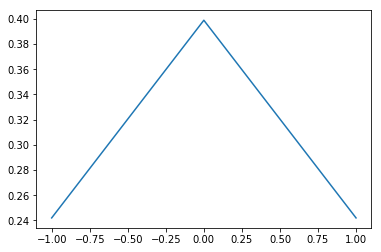

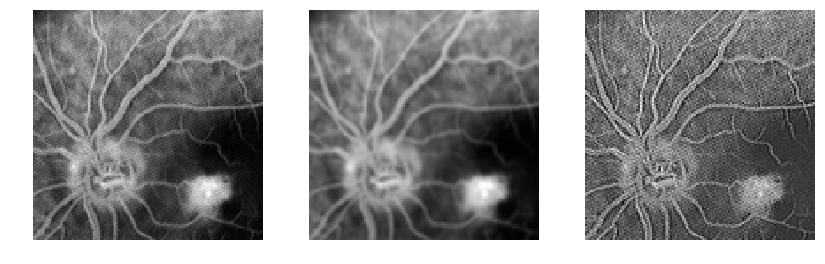

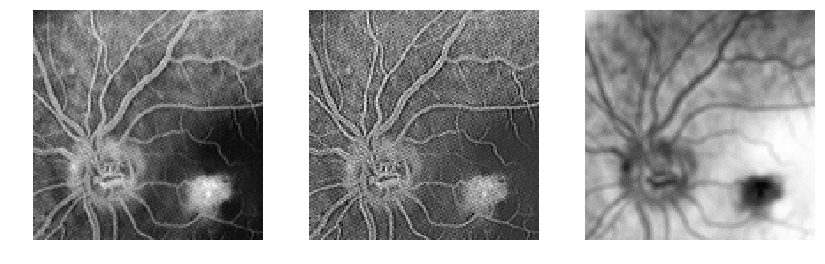

In [8]:
f_ex1 = np.array(mpimg.imread('../data/retina.tif')).astype('float32')

gauss_kernel1_ex1 = gauss_kernel(3, 1, 0)

f_ex1_filtered = sc.convolve2d(f_ex1, gauss_kernel1_ex1, mode='same')

# f_ex1_filtered = ia.normalize(sn.gaussian_filter(f_ex1, 1))

df_ex1 = f_ex1 - f_ex1_filtered

fig1_ex1 = plt.figure(figsize=(14,14))

fig1_ex1.add_subplot(131).axis('off')
plt.imshow(f_ex1[20:150,20:150], cmap='gray')

fig1_ex1.add_subplot(132).axis('off')
plt.imshow(f_ex1_filtered[20:150,20:150], cmap='gray')

fig1_ex1.add_subplot(133).axis('off')
plt.imshow(df_ex1[20:150,20:150], cmap='gray')

plt.show()

fig2_ex1 = plt.figure(figsize=(14,14))

fig2_ex1.add_subplot(131).axis('off')
plt.imshow((ia.normalize(border_highlight(f_ex1, df_ex1, .5))[20:150,20:150]), cmap='gray')

fig2_ex1.add_subplot(132).axis('off')
plt.imshow(border_highlight(f_ex1, df_ex1, 1)[20:150,20:150], cmap='gray')

fig2_ex1.add_subplot(133).axis('off')
plt.imshow(border_highlight(f_ex1, df_ex1, 4.5)[20:150,20:150], cmap='gray')

plt.show()

## 2. Filtro de Sobel

Existem vários filtros que procuram realçar as bordas da imagem. Um dos mais conhecidos é o Operador Sobel, composto por uma máscara vertical (Sv) e uma máscara horizontal (Sh).

In [9]:
import numpy as np

Sv = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
print('Sv =\n',Sv)

Sh = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
print('Sh =\n',Sh)



Sv =
 [[ 1  0 -1]
 [ 2  0 -2]
 [ 1  0 -1]]
Sh =
 [[ 1  2  1]
 [ 0  0  0]
 [-1 -2 -1]]


### 2.1 Implementar o operador Magnitude Sobel de uma imagem.

A função MagSobel a ser implementada possui como parâmetro a imagem de entrada e deve seguir a seguinte equação:

$$MagSobel = \sqrt{f_h^2 + f_v^2}$$

onde $f_h$ é a imagem de entrada convolvida com o operador de Sobel horizontal e $f_v$ é a imagem de entrada convolvida com o operador de Sobel vertical.

Existem alguns cuidados necessários:

- As operações devem todas serem feitas em ponto flutuante e os valores finais serão maiores de 255. Assim, a função que calcula a magnitude do gradiente Sobel é feita de acordo com a equação dada. 
- Lembre-se que para visualizar a imagem será necessário antes normalizar a imagem utilizando, por exemplo, o ianormalize. 
- Adicionalmente, como a máscara Sobel é 3x3, a imagem resultante terá altura e largura maiores que a original por 2x2 pixels já que a imagem resultante da convolução linear é a soma dos tamanhos em cada dimensão, menos 1.



-490.0 760.0 -540.0 597.0


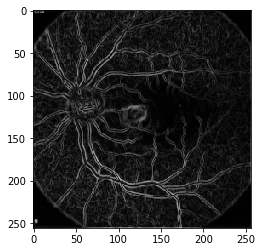

In [109]:
def MagSobel(img):

    Sv = np.array([[1,0,-1],[2,0,-2],[1,0,-1]])
    Sh = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])
    
    fh = sc.convolve2d(img, Sh, mode='same').astype('float')
    fv = sc.convolve2d(img, Sv, mode='same').astype('float')
    
    mag_sobel = np.sqrt((fv**2)+(fh**2))
    
    print('{} {} {} {}'.format(fh.min(), fh.max(), fv.min(), fv.max()))
    return mag_sobel, fv, fh

f = mpimg.imread('../data/retina.tif')
sobel = MagSobel(f)
plt.imshow(sobel[0], cmap='gray')
plt.show()

### 2.2 Implementar uma funcao que retorna o ângulo da borda de Sobel

Após implementar a função que retorna o ângulo da borda de Sobel:
- calcule o histograma da distribuição deste ângulo, somente para valores de magnitude de borda acima de um limiar $T$;
- visualize a imagem de ângulo utilizando uma tabela de cores circular para os ângulos e uma cor diferente para usar nos locais onde a magnitude for menor que $T$. Plote junto com a figura, a tabela de cores usada;


In [27]:
def sobel_angle(fv, fh):
    return(np.arctan2(fh, fv))

In [199]:
f = mpimg.imread('../data/retina.tif')
sobel = MagSobel(f)
angles = np.abs(sobel_angle(sobel[2], sobel[1]))
print(angles.max())
print(angles.min())
print(sobel[0].min())

-490.0 760.0 -540.0 597.0
3.141592653589793
0.0
0.0


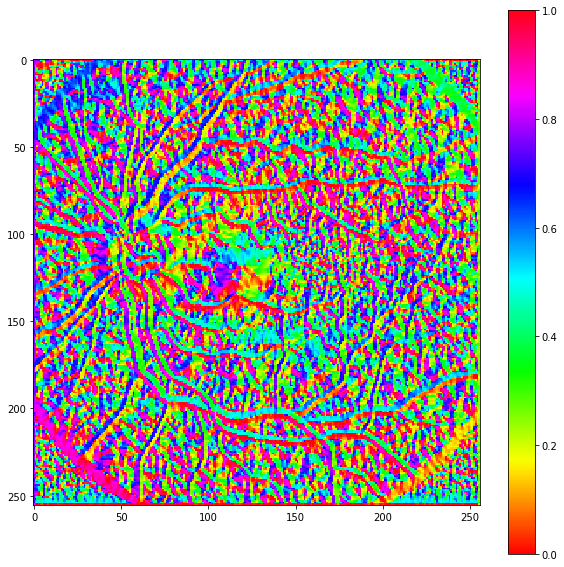

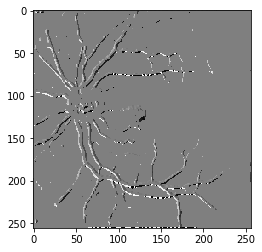

In [228]:
import matplotlib.colors as colors
angles_color_hsv = np.ones((angles.shape[0], angles.shape[1], 3))
angles_color_hsv[:,:,0] = ia.normalize(angles, [0, 1])
# angles_color_hsv[:,:,0] = np.linspace(0, 1, 256*256).reshape((256, 256))

# dt = np.select([m > 2], [t]) # where m = magsobel and t = angles

dt = np.select([sobel[0] > 200], [angles])

# angles_color_hsv[:,:,0] = np.clip(ia.normalize(dt, [0, 1]), .5, 1)
fig = plt.figure(figsize=[10, 10])

a = ia.normalize(colors.hsv_to_rgb(angles_color_hsv), [0, 180])
plt.imshow(ia.normalize(colors.hsv_to_rgb(angles_color_hsv), [0, 1]), cmap='hsv')
plt.hsv()
plt.colorbar()
plt.show()

plt.imshow(ia.normalize(dt), cmap='gray')
plt.show()

-490.0 760.0 -540.0 597.0
-433.0 510.0 -540.0 506.0
[ 26.          35.0142828   45.45327271 145.36161804 229.99565213
 244.72433471 211.44266362 147.52626885 124.42668524 179.12007146]
[ 50.11985634  87.4185335  264.12118431 296.71872202 323.12536267
 299.28581657 255.98828098 127.47548784 292.24989307 384.25512358]
769.1059744924622
594.22554640473


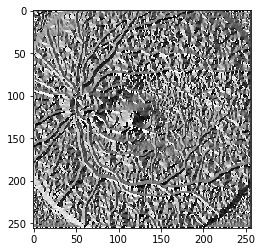

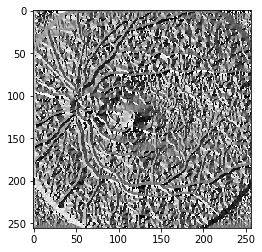

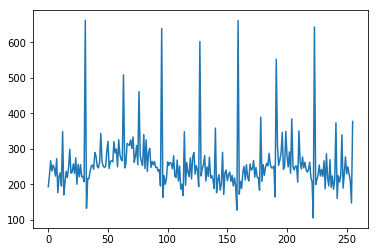

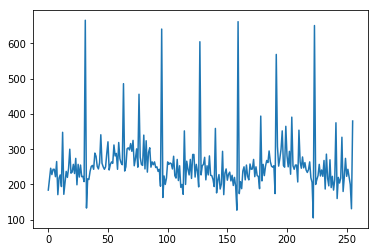

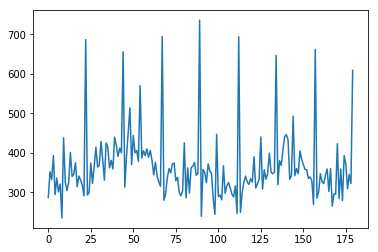

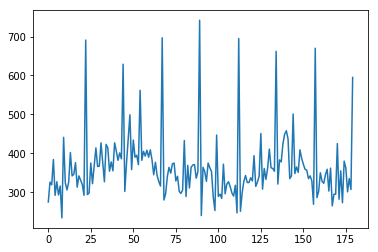

In [227]:
f = mpimg.imread('../data/retina.tif')
# f = mpimg.imread('../figures/fusca.png')
sobel = MagSobel(f)

iasobel1 = iasobel(f)
# dt = np.select()
print(iasobel1[0][0,:10])

angles = (sobel_angle(sobel[2], sobel[1]))

print(sobel[0][0,:10])

print(sobel[0].max())
print(iasobel1[0].max())

angles_color = np.zeros((angles.shape[0], angles.shape[1], 3))

plt.imshow(angles, cmap='gray')
plt.show()

plt.imshow(iasobel1[1], cmap='gray')
plt.show()

plt.plot(ia.histogram(ia.normalize(angles, [0, 255])))
plt.show()

plt.plot(ia.histogram(ia.normalize(iasobel1[1], [0, 255])))
plt.show()

(h1,g1) = np.histogram(angles, bins = 180)
(h2,g2) = np.histogram(iasobel1[1], bins = 180)

plt.plot(h1)
plt.show()

plt.plot(h2)
plt.show()

## 3. Propriedades da convolução

Realize experimentos para demostrar as propriedades da convolução:

- Comutativa $$f(x,y)*g(x,y) = g(x,y)*f(x,y)$$
- Associativa $$f(x,y)*[g(x,y)*h(x,y)] = [f(x,y)*g(x,y)]*h(x,y)$$

Crie um exemplo que demonstre como usar a propriedade associativa para realizar a filtragem de uma imagem por um filtro passa-faixa. (Dica: use uma máscara passa-baixas e uma máscara passa-altas).